In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, KDTree
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

# A light introduction to Graph Theory

## Introduction
Welcome scientists!

You are working with experimental collaborators to build a model of a developmental system. The process studied begins with one stem cell that divides repeatedly over the course of 48 hours. At the end of this developmental time window, the scientists take z-stack microscopy images of the full cluster of cells and use automated cell segmentation software to find the centroid of each cell. You are provided with this centroid data.

In [59]:
# Generating in-silico centroid data

# Set seed for reproducibility
np.random.seed(0)

# Generate 2 populations of centroids with slightly different distributions
n_cells = 50

# Graph 1: Random uniform points in cube
centroids1 = np.random.rand(n_cells, 3)

# Graph 2: Long, skinny cloud with clustered ends and bridging points
cluster_centers = np.array([[0.3, 0.3, 0.3], [0.7, 0.7, 0.7]])
n_cluster = n_cells // 2 - 5  # leave room for bridging cells
n_bridge = 6  # number of intermediate cells

# Clusters with Gaussian noise
cluster_points = np.vstack([
    center + 0.05 * np.random.randn(n_cluster, 3)
    for center in cluster_centers
])

# Bridge: Uniformly distributed points along the line between clusters
bridge_line = np.linspace(cluster_centers[0], cluster_centers[1], n_bridge + 2)[1:-1]
bridge_noise = 0.01 * np.random.randn(n_bridge, 3)
bridge_points = bridge_line + bridge_noise

# Combine clusters and bridge
centroids2 = np.vstack([cluster_points, bridge_points])

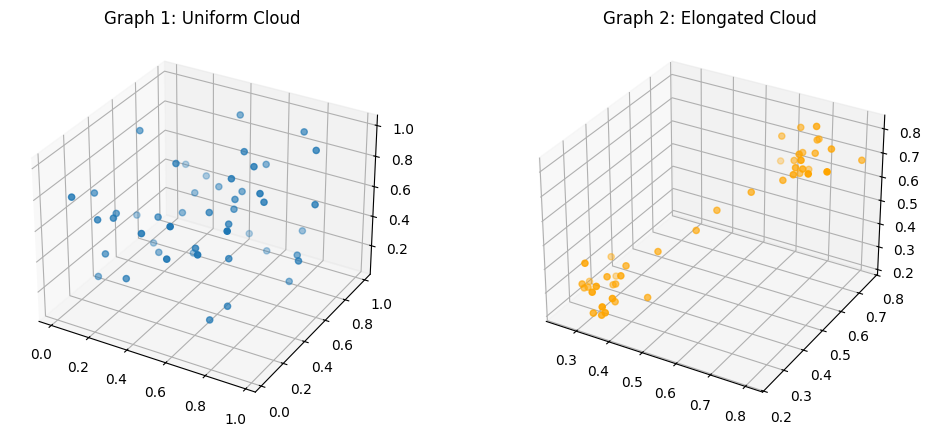

In [64]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*centroids1.T)
ax1.set_title("Graph 1: Uniform Cloud")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*centroids2.T, color='orange')
ax2.set_title("Graph 2: Elongated Cloud")

plt.show()

Visually you can tell which cluster is which, but you need quantitative metrics that differentiate the morphologies so that you can evaluate which morphology your model output resembles more closely.

**Discussion Question:**
- What metrics do you think might best differentiate between these cell clusters (metrics we discussed today or otherwise)?

## Voronoi Tesselation

For the purposes of this notebook, you decide to pursue graph metrics as a potential method for differentiating between these morphologies. You want to make a graph where each cell is a node and edges exist between neighbor cells. However, you do not have adjacency information describing which cells are neighbors. You decide to use Voronoi Tesselation to estimate adjacency from the centroid data.

In [65]:
def build_voronoi_graph(points):
    vor = Voronoi(points)
    G = nx.Graph() # Initialize an empty graph

    # Add nodes with positions
    for i, point in enumerate(points):
        G.add_node(i, pos=point)

    # Ridge points are pairs of indices whose cells share a Voronoi ridge (an edge in the Voronoi diagram)
    for p1, p2 in vor.ridge_points:
        G.add_edge(p1, p2)

    return G

In [66]:
G1 = build_voronoi_graph(centroids1)
G2 = build_voronoi_graph(centroids2)

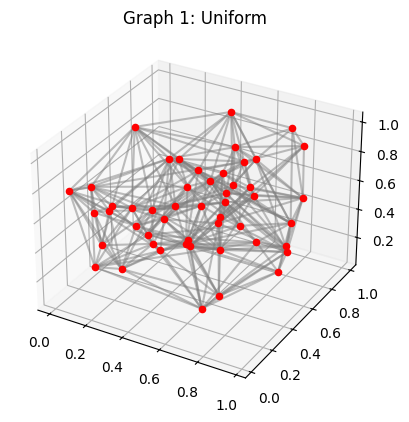

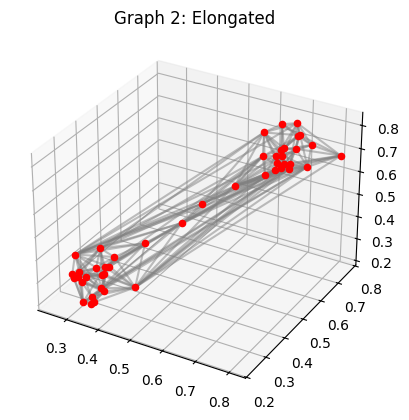

In [67]:
def draw_graph_3d(G, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pos = nx.get_node_attributes(G, 'pos')

    for i, j in G.edges():
        xs, ys, zs = zip(pos[i], pos[j])
        ax.plot(xs, ys, zs, color='gray', alpha=0.5)

    for i, p in pos.items():
        ax.scatter(*p, color='red')

    ax.set_title(title)
    plt.show()

draw_graph_3d(G1, "Graph 1: Uniform")
draw_graph_3d(G2, "Graph 2: Elongated")

**Discussion Question:**
- For which cell cluster does the Voronoi estimated adjacency seem more accurate? In what circumstances might Voronoi tesselation be a more vs less accurate way of estimating cell adjacency from centroid data?

## Graph Metrics

Now you have graphs! Very exciting! Next you want to evaluate whether these graphs differ according to standard graph metrics like the mean node clustering coefficient, the mean node degree, the mean node eccentricity, the graph radius, and the graph diameter.

Discussion Questions:
- What is a node's degree? When do we expect average node degree to be high? When do we expect it to be low?
- What is a node's clustering coefficient? When do we expect the clustering coefficient to be high vs low?
- What is a node's eccentricity? When do we expect the eccentricity to be high vs low?
- What is a graph's radius? When do we expect the radius to be high vs low?
- What is a graph's diameter? When do we expect the diameter to be high vs low?
- For each of these metrics, which of the clusters do you expect to be higher vs lower? (Or do you expect them to be roughly equal)?

The function below calculates these graph metrics for a provided graph. Use the function to compare graph metrics between G1 and G2.

In [70]:
def graph_metrics(G):
    metrics = {}

    # Average clustering is defined for any graph
    metrics["average_clustering"] = nx.average_clustering(G)

    # Degree-based metrics
    degrees = [d for _, d in G.degree()]
    metrics["avg_degree"] = np.mean(degrees)

    # Handle connected-only metrics safely
    if nx.is_connected(G):
        ecc = nx.eccentricity(G)
        metrics["eccentricity_mean"] = np.mean(list(ecc.values()))
        metrics["radius"] = nx.radius(G)
        metrics["diameter"] = nx.diameter(G)
    else:
        print("Warning: Graph is not connected. Skipping eccentricity, radius, and diameter.")
        metrics["eccentricity_mean"] = None
        metrics["radius"] = None
        metrics["diameter"] = None

    return metrics

In [72]:
# Use the function above to calculate graph metrics for G1 and G2


In [ ]:
metrics1 = graph_metrics(G1)
metrics2 = graph_metrics(G2)

pd.DataFrame([metrics1, metrics2], index=["Graph 1", "Graph 2"])

Discussion Question:
- Comparing the metrics between the two morphologies, how do they compare to your expectations?

## Refining the graphs

When building the graph above, we drew an edge between all cells that are adjacent in the Vorronoi diagram. This potentially led to the addition of some unlikely edges between centroids on either end of the elongated cluster. Instead, we can limit the graph so edges are only added between nodes and their k nearest neighbors.

In [ ]:
def build_neighbor_limited_voronoi_graph(points, num_neighbors):
    tree = KDTree(points)
    G = nx.Graph()

    for i, p in enumerate(points):
        G.add_node(i, pos=p)
        # Connect to num_neighbors nearest neighbors (approx Voronoi)
        dists, idxs = tree.query(p, k=num_neighbors)  # num_neighbors nearest neighbors + self
        for j in idxs[1:]:
            G.add_edge(i, j)

    return G

Run the cells below to construct new graphs using this function and to compare their graph metrics. Change the value assigned to num_neighbors to see how imposing a number of neighbors on each node affects overall graph metrics

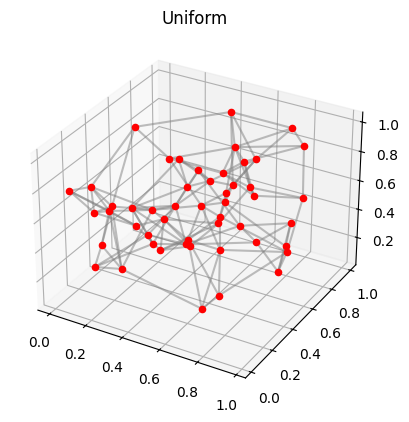

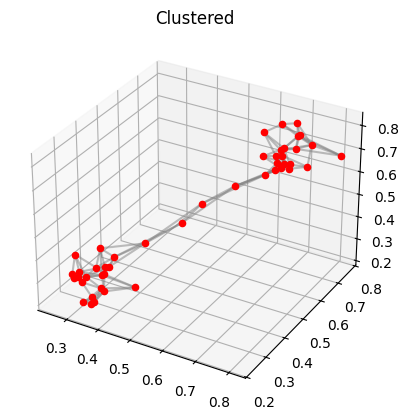

In [81]:
num_neighbors = 5

G1 = build_neighbor_limited_voronoi_graph(centroids1, num_neighbors)
G2 = build_neighbor_limited_voronoi_graph(centroids2, num_neighbors)
draw_graph_3d(G1, "Uniform")
draw_graph_3d(G2, "Clustered")

In [82]:
metrics1 = graph_metrics(G1)
metrics2 = graph_metrics(G2)
pd.DataFrame([metrics1, metrics2], index=["Graph 1", "Graph 2"])

,average_clustering,avg_degree,eccentricity_mean,radius,diameter
Graph 1,0.464381,5.160000,5.320000,4,6
Graph 2,0.525880,5.217391,8.282609,5,10


Discussion questions:
- Which graph metrics are explicitely limited by imposing a number of neighbors for each node?
- Why is the average degree greater than the number provided to num_neighbors?
- When might you want to impose a number of neighbors on each node in a graph? When would it be best to avoid imposing numbers of neighbors in a graph?